# Road Signs Deep Learning classification 

---

![banner](banner.jpg)

---

## Content Table
- [1. Environment Preparation](#0.-Environment-Preparation)
- [2. Data Preprocessing](#2.-Data-Preprocessing)
  - [A. Data Loading](#A.-Data-Loading)
  - [B. Data Augmentation](#B.-Data-Augmentation)
- [3. Model Development](#3.-Model-Development)
- [4. Model Evaluation](#4.-Model-Evaluation)
- [5. Results Interpretation](#5.-Results-Interpretation)
  - [A. Misclassification](#A.-Misclassification)

### Project Overview
This project aims to classify road signs using a Convolutional Neural Network (CNN), important for autonomous driving systems. The GTSRB dataset is used, with data augmentation and model optimization techniques applied to improve performance.

### Objectives
- Classify road signs using CNNs.
- Preprocess and augment the GTSRB dataset.
- Design, train, and evaluate the CNN model.
- Optimize performance with techniques like regularization and transfer learning.
- Interpret the model predictions and evaluation results

### Dataset
The **GTSRB dataset** contains 50,000+ images of road signs. It will be split into training, validation, and test sets with data augmentation to increase robustness & generalization.

### Dependencies
- **Python**, **TensorFlow/Keras**, **Scikit-learn**, **OpenCV**, **Numpy**, **Pandas**, **Matplotlib**, **Seaborn**

---

## 1. Environment Preparation

In [1]:
import tensorflow as tf

# List all Gpus
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU detected.")

No GPU detected.


In [2]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import randint
import matplotlib.pyplot as plt
import tensorflow.keras as keras

random_seed = 42 # Set random seed for reproducibility

In [3]:
train_data_path = "Data/archive/" # Path to the training data
# train_data_path = r'C:\Users\33623\OneDrive - Université de Limoges\Documents\Data_analytics_Sorbonne\14_Deepl_Learning\archive\Train.csv'
image_size = (64, 64) # Target image size for the model
model_export_path = "Model/traffic_sign_classifier.keras" # Path to save the model
model_path = "Model/traffic_sign_classifier.keras" # Path to load the model

---

## 2. Data Preprocessing

### A. Data Loading

In [4]:
def load_data(meta_data, data_path, image_size, is_test=False):
    """
    Loads and preprocesses image data for training or testing.

    Parameters:
    meta_data (pd.DataFrame): A DataFrame containing metadata about the images, including file paths and class IDs.
    data_path (str): The base directory path where the image files are located.
    image_size (tuple): The target size for resizing the images (width, height).
    is_test (bool): A flag indicating whether the data is for testing. If True, the labels are not one-hot encoded.

    Returns:
    tuple: A tuple containing:
        - X (np.ndarray): An array of preprocessed images.
        - Y (np.ndarray): An array of labels, either one-hot encoded or as class IDs depending on the is_test flag.
    """
    # Encode labels as one-hot vectors if not in test mode, otherwise use class IDs directly
    Y = (
        keras.utils.to_categorical(meta_data["ClassId"])
        if not is_test
        else meta_data["ClassId"]
    )
    
    # Load and preprocess images
    X = np.array(
        [
            np.array(
                # Read image, convert from BGR to RGB, resize to target size
                cv2.resize(cv2.imread(data_path + path)[..., ::-1], image_size),
                dtype=np.float64,
            )
            for path in tqdm(meta_data.Path)  # Iterate over all image paths with a progress bar
        ]
    )
    
    # Return preprocessed images and labels
    return X, Y

In [5]:
train_meta_data = pd.read_csv("Data/archive/Train.csv")
train_meta_data = train_meta_data[["ClassId", "Path"]]
print("Loading training data...")
X, Y = load_data(train_meta_data, train_data_path, image_size)
print(f"Loaded {len(X)} training samples.")

Loading training data...


100%|██████████| 39209/39209 [04:32<00:00, 143.91it/s]


Loaded 39209 training samples.


In [6]:
X.shape, Y.shape

((39209, 64, 64, 3), (39209, 43))

In [7]:
train_meta_data.ClassId.unique()

array([20,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

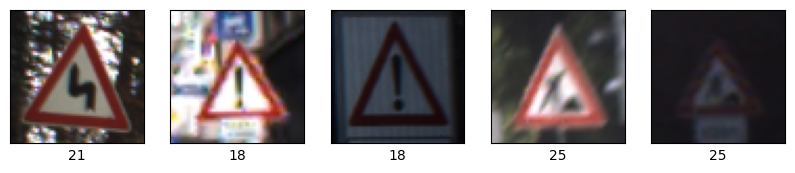

In [8]:
def plot_random_samples(meta_data, X):
    """
    Plots random samples of images with their corresponding class IDs.

    Parameters:
    meta_data (pd.DataFrame): A DataFrame containing metadata about the images, including class IDs.
    X (np.ndarray): An array of preprocessed images.

    Returns:
    None
    """
    # Create a figure with 1 row and 5 columns of subplots
    fig, axes = plt.subplots(1, 5, figsize=(10, 5))
    
    for i in range(5):
        # Select a random index
        n = randint(0, len(X))
        
        # Display the image in the subplot
        axes[i].imshow(X[n] / 255)
        
        # Set the label of the subplot to the class ID of the image
        axes[i].set_xlabel(meta_data.ClassId.iloc[n])
        
        # Remove x and y ticks
        axes[i].set_xticks(())
        axes[i].set_yticks(())
    
    plt.show()

# Call the function to plot random samples from the training data
plot_random_samples(train_meta_data, X)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=random_seed,
    # stratify=Y,
)

In [10]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((31367, 64, 64, 3), (7842, 64, 64, 3), (31367, 43), (7842, 43))

### B. Data Augmentation

In [11]:
# Create an ImageDataGenerator for data augmentation during training
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,  # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Randomly shift images vertically by 10% of the height
    zoom_range=0.1,  
    rotation_range=10,  
    brightness_range=[0.9, 1.1],  
)

# Create an iterator for the training data with a batch size of 64
it_train = train_datagen.flow(X_train, Y_train, batch_size=64)

it_val = train_datagen.flow(X_val, Y_val, batch_size=64)

---

## 3. Model Development

In [12]:
from keras.models import Sequential
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Rescaling,
    Input,
)

# Create the model structure
model = Sequential(
    [
        Input(shape=(64, 64, 3)),
        Rescaling(1.0 / 255.0),
        Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(units=256, activation="relu"),
        Dropout(0.5),
        Dense(units=43, activation="softmax"),
    ]
)


print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,779 (940.54 KB)

 Trainable params: 240,299 (938.67 KB)

 Non-trainable params: 480 (1.88 KB)

None


In [13]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
earlystop = keras.callbacks.EarlyStopping(patience=4) # Stop training early if the validation loss stops improving

history = model.fit(it_train, validation_data=it_val, epochs=30, callbacks=[earlystop])

Epoch 1/30


c:\Users\33623\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 58s 110ms/step - accuracy: 0.4538 - loss: 2.0567 - val_accuracy: 0.7297 - val_loss: 0.9671
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 52s 106ms/step - accuracy: 0.9068 - loss: 0.2986 - val_accuracy: 0.9633 - val_loss: 0.1240
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 50s 102ms/step - accuracy: 0.9500 - loss: 0.1547 - val_accuracy: 0.9819 - val_loss: 0.0625
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 49s 99ms/step - accuracy: 0.9704 - loss: 0.0900 - val_accuracy: 0.9643 - val_loss: 0.1083
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9792 - loss: 0.0695 - val_accuracy: 0.9853 - val_loss: 0.0451
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 49s 100ms/step - accuracy: 0.9807 - loss: 0.0618 - val_accuracy: 0.9843 - val_loss: 0.0472
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 53s 107ms/step - accuracy: 0.9841 - loss: 0.0531 - val_accuracy: 0.9834 - val_loss: 0.0528
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 50s 102ms/step - accuracy: 0.9833 - loss: 0.0534 - val_a

Max val_acc 0.9928589463233948


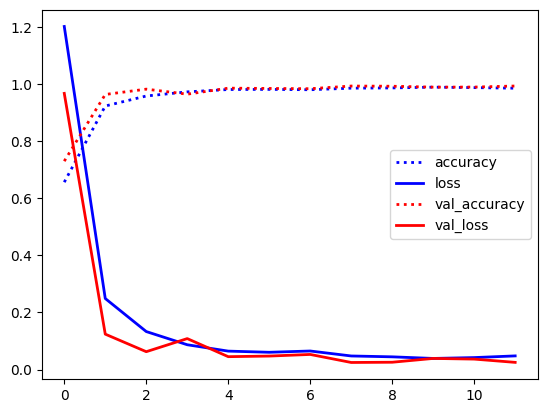

In [19]:
import pandas as pd
import numpy as np

pd.DataFrame(history.history).plot(lw=2, style=["b:", "b-", "r:", "r-"]) # PLot the training and validation metrics
print("Max val_acc", np.max(history.history["val_accuracy"]))

In [20]:
model.save(model_export_path) # Save the model

---

## 4. Model Evaluation

Uncomment the line below to load the saved model

In [17]:
#model = keras.models.load_model(model_path) # Load the model

In [21]:
test_data_path = "Data/archive/"
test_meta_data = pd.read_csv("Data/archive/Test.csv")
test_meta_data = test_meta_data[["ClassId", "Path"]]
print("Loading test data...")
X_test, Y_test = load_data(test_meta_data, test_data_path, image_size, is_test=True) # Load the test data
print(f"Loaded {len(X_test)} test samples.")

Loading test data...


100%|██████████| 12630/12630 [01:16<00:00, 165.30it/s]


Loaded 12630 test samples.


In [22]:
X_test.shape, Y_test.shape

((12630, 64, 64, 3), (12630,))

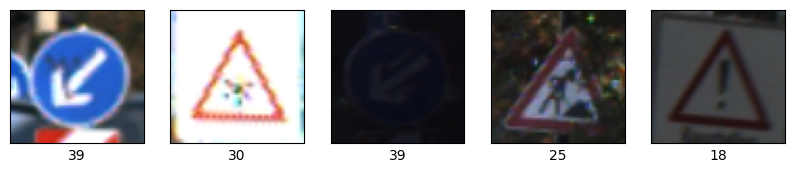

In [23]:
plot_random_samples(test_meta_data, X_test)

In [24]:
pred = model.predict(X_test, verbose=1) # Make predictions on the test data

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [25]:
pred.shape

(12630, 43)

In [26]:
Y_pred = np.argmax(pred, axis=1)
Y_pred[:5]

array([16,  1, 38, 33, 11], dtype=int64)

In [27]:
Y_test

0        16
1         1
2        38
3        33
4        11
         ..
12625    12
12626    33
12627     6
12628     7
12629    10
Name: ClassId, Length: 12630, dtype: int64

In [28]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
)

print(classification_report(Y_test, Y_pred))
print("Accuracy: ", accuracy_score(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      0.99      0.99       720
           2       0.99      0.99      0.99       750
           3       0.98      0.95      0.96       450
           4       1.00      0.99      0.99       660
           5       0.93      0.98      0.95       630
           6       1.00      0.93      0.96       150
           7       0.99      0.99      0.99       450
           8       1.00      0.92      0.96       450
           9       0.99      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.93      0.96       420
          12       1.00      0.99      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      0.99      0.99       270
          15       0.99      1.00      0.99       210
          16       0.99      1.00      0.99       150
          17       0.99    

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, Y_pred) # Compute the confusion matrix

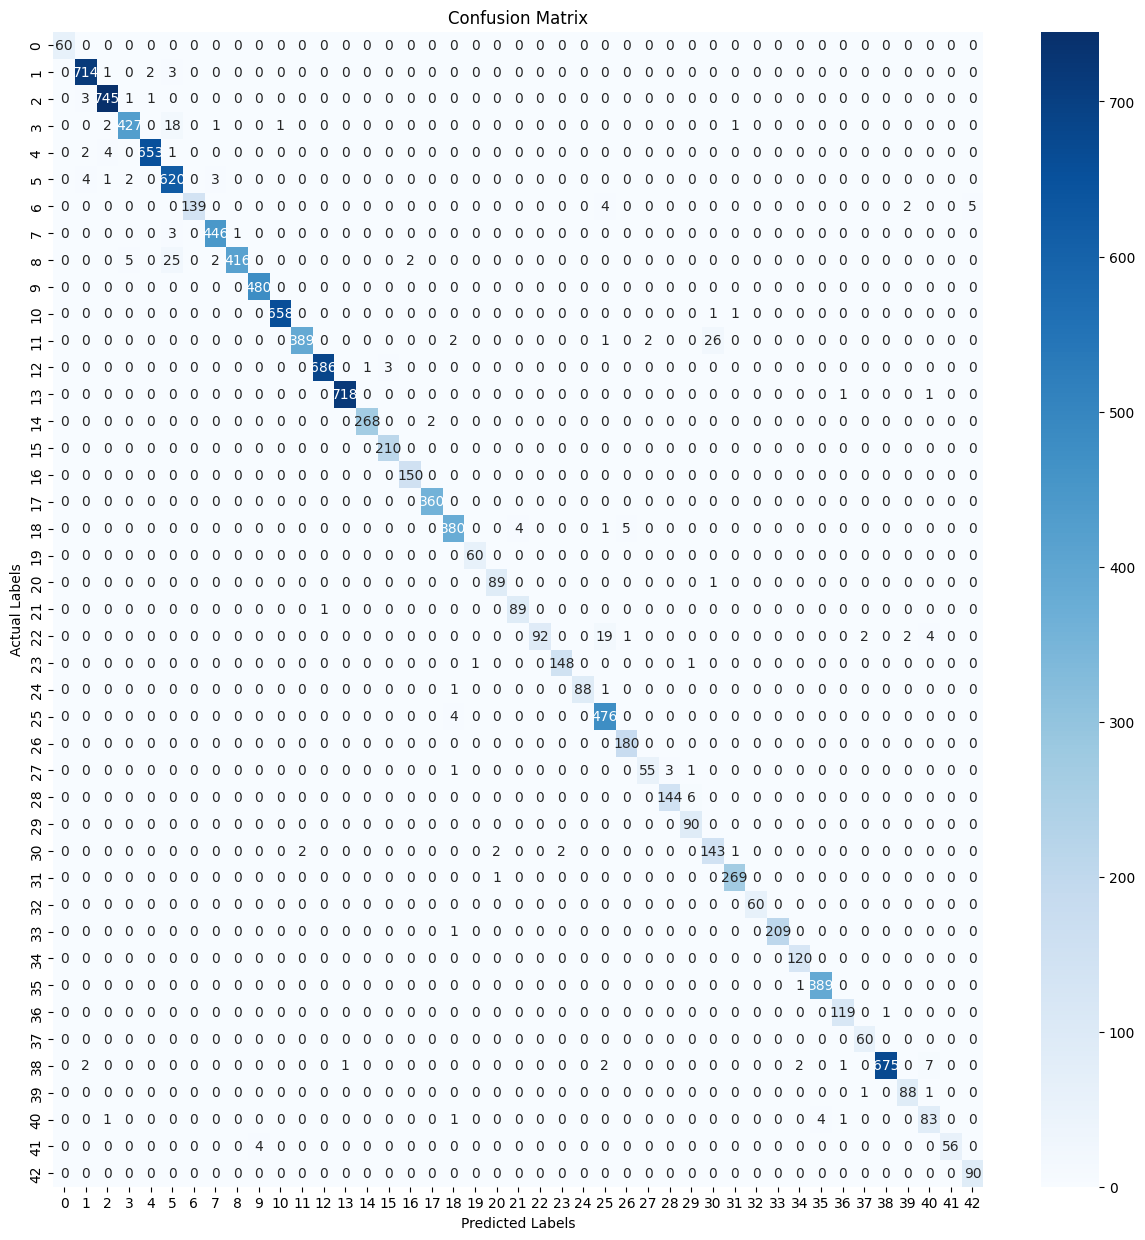

In [30]:
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

---

## 5. Interpretation

### A. Misclassification

In [31]:
Y_test.shape,Y_pred.shape # Verify the shapes of the true and predicted labels

((12630,), (12630,))

In [32]:
misclassified_samples = np.nonzero(Y_test != Y_pred)[0] # Find the indices of misclassified samples
misclassified_samples.shape

(239,)

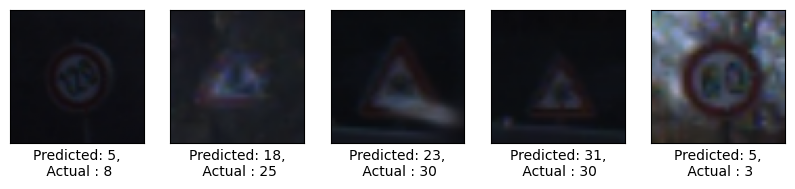

In [33]:
# Visualize the (first five) misclassifications, together with the predicted and actual class
nb_misclassifications = 5
fig, axes = plt.subplots(1, nb_misclassifications,  figsize=(10, nb_misclassifications))
for nr, i in enumerate(misclassified_samples[:nb_misclassifications]):
    axes[nr].imshow(X_test[i]/255.0)
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (Y_pred[i],Y_test[i]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show()

### B. Prediction Visualization - GradCam

## 1. Importing Libraries

In [35]:
# Import necessary libraries
import tensorflow as tf  # TensorFlow for building and training models
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for plotting images
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Functions for loading and preprocessing images
from tensorflow.keras.models import load_model, Model  # Functions for loading models and building Keras models
from tensorflow.keras.layers import Input  # Input layer for model definition


## 2. Defining Image Preprocessing Function

In [36]:
# Function to preprocess the image
def preprocess_image(img_path, target_size):
    # Load the image and resize it to the target size
    img = load_img(img_path, target_size=target_size)
    # Convert the image to a NumPy array
    img = img_to_array(img)
    # Add an extra dimension to match the model's input shape (batch size)
    img = np.expand_dims(img, axis=0)
    return img  # Return the preprocessed image


## 3. Loading and Preprocessing the Image

In [55]:
# Path to the image and preprocessing
img_path = 'Data/archive/Train/31/00031_00025_00029.png'  # Specify the path to the input image
img_array = preprocess_image(img_path, target_size=(64, 64))  # Preprocess the image
print("Shape of the image:", img_array.shape)  # Print the shape of the preprocessed image


Shape of the image: (1, 64, 64, 3)


## 4. Loading the Model

In [56]:
# Load the model
original_model = load_model('Model/traffic_sign_classifier.keras')  # Load the trained model from file
print("Model loaded successfully")  # Confirm successful model loading


Model loaded successfully


## 5. Recreating the Model for Intermediate Outputs

In [57]:
print(model.summary())

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,779 (940.54 KB)

 Trainable params: 240,299 (938.67 KB)

 Non-trainable params: 480 (1.88 KB)

None


In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import tensorflow as tf

# Recreate the model to get outputs from intermediate layers
input_layer = Input(shape=(64, 64, 3))  # Define an input layer for the model
x = input_layer  # Initialize the variable x with the input layer

# Liste pour stocker les sorties des couches de convolution
conv_outputs = []  

# Loop through the original model's layers
for layer in original_model.layers:
    if isinstance(layer, tf.keras.layers.InputLayer):  # Skip the input layer
        continue
    x = layer(x)  # Pass the input through the current layer
    if 'conv' in layer.name:  # Stocke les sorties de toutes les couches de convolution
        conv_outputs.append(x)  # Ajouter la sortie à la liste

# Create a new model with the defined input and the outputs from the convolutional layers and final layer
model = Model(inputs=input_layer, outputs=[conv_outputs, x])  # Define the new model


## 6. Defining the Grad-CAM Computation Function

In [59]:
def compute_grad_cam(model, img_array, class_index):
    with tf.GradientTape() as tape:  # Record the operations for automatic differentiation
        conv_outputs, predictions = model(img_array)  # Get outputs from the model
        loss = predictions[:, class_index]  # Select the loss corresponding to the specified class index

    grads = tape.gradient(loss, conv_outputs)  # Compute the gradients of the loss with respect to the convolutional outputs
    pooled_grads = [tf.reduce_mean(grad, axis=(0, 1, 2)) for grad in grads]  # Pool the gradients for each conv output

    heatmaps = []  # List to store heatmaps for each conv output
    for conv_output, pooled_grad in zip(conv_outputs, pooled_grads):
        conv_output = conv_output[0]  # Remove the batch dimension
        # Compute the Grad-CAM heatmap by multiplying pooled gradients with convolutional outputs
        heatmap = tf.reduce_mean(tf.multiply(pooled_grad, conv_output), axis=-1)
        
        # Scale the heatmap
        heatmap = tf.maximum(heatmap, 0)  # Set negative values to zero
        heatmap /= tf.math.reduce_max(heatmap)  # Normalize the heatmap
        heatmaps.append(heatmap.numpy())  # Add the heatmap to the list

    return heatmaps  # Return the list of heatmaps as NumPy arrays


## 7. Calculating and Visualizing Grad-CAM

Grad-CAM computed successfully


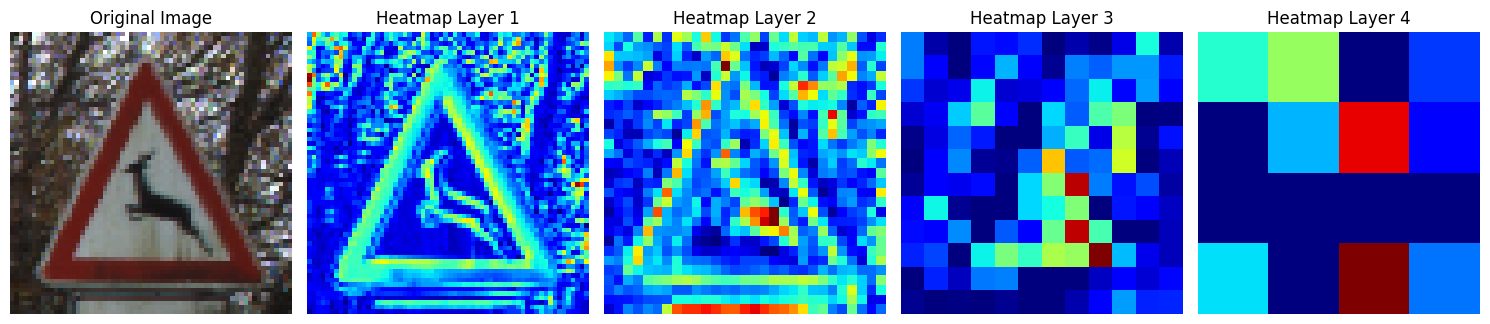

In [60]:
import matplotlib.pyplot as plt

# Compute Grad-CAM
try:
    class_index = 31  # Replace with the appropriate class index
    heatmaps = compute_grad_cam(model, img_array, class_index)  # Compute the Grad-CAM heatmaps
    print("Grad-CAM computed successfully")  # Confirm successful computation

    # Display Grad-CAM results
    num_layers = len(heatmaps)  # Get the number of layers for the heatmaps
    plt.figure(figsize=(15, 5 + num_layers * 2))  # Set figure size based on the number of layers

    plt.subplot(1, num_layers + 1, 1)  # Create a subplot for the original image
    plt.imshow(img_array[0].astype("uint8"))  # Display the original image
    plt.title('Original Image')  # Title for the original image
    plt.axis('off')  # Hide the axis

    # Loop through heatmaps and display each one
    for i in range(num_layers):
        plt.subplot(1, num_layers + 1, i + 2)  # Create a subplot for each heatmap
        plt.imshow(heatmaps[i], cmap='jet')  # Display the heatmap with a color map
        plt.title(f'Heatmap Layer {i + 1}')  # Title for the heatmap
        plt.axis('off')  # Hide the axis

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Show the plots

except Exception as e:
    print(f"An error occurred: {str(e)}")  # Print any errors that occur
    import traceback  # Import traceback for debugging
    traceback.print_exc()  # Print the stack trace for the error
